BEGINING

In [19]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import os
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn as nn
from torchvision.models.video import r2plus1d_18
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm import tqdm


PREPROCESSING FOR MODEL

In [20]:
class MultiStreamDatasetRAM(Dataset):
    def __init__(self, rgb_root, flow_root, categories, sequence_length=16, stride=8, transform=None):
        
        self.rgb_data = []
        self.flow_data = []
        self.labels = []
        self.sequence_length = sequence_length
        self.transform = transform

        for label, category in enumerate(categories):
            # Load RGB frames
            rgb_path = os.path.join(rgb_root, category)
            rgb_files = sorted([os.path.join(rgb_path, f) for f in os.listdir(rgb_path) if f.endswith(".png")])

            # Load optical flow frames
            flow_path = os.path.join(flow_root, category)
            flow_files = sorted([os.path.join(flow_path, f) for f in os.listdir(flow_path) if f.endswith(".png")])

            # Align datasets by truncating to the shorter length
            min_length = min(len(rgb_files), len(flow_files))
            rgb_files = rgb_files[:min_length]
            flow_files = flow_files[:min_length]

            print(f"Preloading category: {category} (RGB: {len(rgb_files)}, Flow: {len(flow_files)})")

            # Load and process sequences
            rgb_frames = [self.transform(Image.open(f).convert("RGB")) for f in rgb_files]
            flow_frames = [self.transform(Image.open(f).convert("RGB")) for f in flow_files]

            for i in range(0, min_length - sequence_length + 1, stride):
                self.rgb_data.append(rgb_frames[i:i + sequence_length])
                self.flow_data.append(flow_frames[i:i + sequence_length])
                self.labels.append(label)

    def __len__(self):
        return len(self.rgb_data)

    def __getitem__(self, idx):
        rgb_sequence = torch.stack(self.rgb_data[idx], dim=1)  # Shape: (C, T, H, W)
        flow_sequence = torch.stack(self.flow_data[idx], dim=1)  # Shape: (C, T, H, W)
        label = self.labels[idx]
        return (rgb_sequence, flow_sequence), label


DATALOADER

In [ ]:
# Define categories
categories = ["Shoplifting", "RoadAccidents", "Fighting"]

# Transformation for preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


# Load multi-stream datasets into RAM
train_dataset = MultiStreamDatasetRAM(
    rgb_root="Train/",
    flow_root="OpticalFlowTrain/",
    categories=categories,
    sequence_length=16,
    stride=8,
    transform=transform
)




print(f"Train dataset loaded with {len(train_dataset)} sequences")
#print(f"Test dataset loaded with {len(test_dataset)} sequences")

# DataLoaders
from torch.utils.data import DataLoader

batch_size = 16  # Adjust based on GPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


Preloading category: Shoplifting (RGB: 24834, Flow: 24834)
Preloading category: RoadAccidents (RGB: 23485, Flow: 23485)
Preloading category: Fighting (RGB: 24683, Flow: 24683)
Train dataset loaded with 9121 sequences


MODEL ONE

In [5]:
import torch.nn as nn
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights

class OptimizedMultiStreamR2Plus1D(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedMultiStreamR2Plus1D, self).__init__()

        # Shared stream (pretrained backbone)
        self.shared_stream = r2plus1d_18(weights=R2Plus1D_18_Weights.DEFAULT)
        in_features = self.shared_stream.fc.in_features  # Save in_features before replacing fc
        self.shared_stream.fc = nn.Identity()  # Remove final FC layer

        # Fully connected layers
        self.rgb_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        self.flow_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Fusion layer
        self.fc_fusion = nn.Sequential(
                nn.Linear(2 * num_classes, num_classes),
                nn.Softmax(dim=1)  # Keep Sequential structure if needed
)
    def forward(self, rgb_input, flow_input):
        

        # Process inputs through the shared stream
        rgb_features = self.shared_stream(rgb_input)
        flow_features = self.shared_stream(flow_input)

        # Pass through fully connected layers
        rgb_out = self.rgb_fc(rgb_features)
        flow_out = self.flow_fc(flow_features)

        # Concatenate and pass through fusion layer
        combined_out = torch.cat((rgb_out, flow_out), dim=1)
        
        return self.fc_fusion(combined_out)


MODEL 2

In [13]:
import torch.nn as nn
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights

class OptimizedMultiStreamR2Plus1D(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedMultiStreamR2Plus1D, self).__init__()

        # Shared stream (pretrained backbone)
        self.shared_stream = r2plus1d_18(weights=R2Plus1D_18_Weights.DEFAULT)
        in_features = self.shared_stream.fc.in_features  # Save in_features before replacing fc
        self.shared_stream.fc = nn.Identity()  # Remove final FC layer

        # Fully connected layers
        self.rgb_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        self.flow_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        # Fusion layer
        self.fc_fusion = nn.Linear(2 * num_classes, num_classes)  # Direct Linear layer


    def forward(self, rgb_input, flow_input):
        rgb_features = self.shared_stream(rgb_input)
        flow_features = self.shared_stream(flow_input)

        rgb_out = self.rgb_fc(rgb_features)
        flow_out = self.flow_fc(flow_features)

        combined_out = torch.cat((rgb_out, flow_out), dim=1)
        fused_out = self.fc_fusion(combined_out)  # Single Linear layer

        return fused_out


MODEL 3

In [17]:
import torch.nn as nn
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights

class OptimizedMultiStreamR2Plus1D(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedMultiStreamR2Plus1D, self).__init__()

        # Shared stream (pretrained backbone)
        self.shared_stream = r2plus1d_18(weights=R2Plus1D_18_Weights.DEFAULT)
        in_features = self.shared_stream.fc.in_features  # Save in_features before replacing fc
        self.shared_stream.fc = nn.Identity()  # Remove final FC layer

        # Shared fully connected layer
        self.shared_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)  # Output logits for each modality
        )

        # Fusion layer
        self.fc_fusion = nn.Sequential(
            nn.Linear(2 * num_classes, num_classes),
            nn.ReLU(),
            nn.LayerNorm(num_classes)
        )

    def forward(self, rgb_input, flow_input):
        # Process inputs through shared backbone
        rgb_features = self.shared_stream(rgb_input)
        flow_features = self.shared_stream(flow_input)

        # Process features through shared fully connected layer
        rgb_out = self.shared_fc(rgb_features)
        flow_out = self.shared_fc(flow_features)

        # Concatenate outputs and pass through fusion layer
        combined_out = torch.cat((rgb_out, flow_out), dim=1)
        fused_out = self.fc_fusion(combined_out)

        return fused_out


MODEL 4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2Plus1D(nn.Module):
    """A lightweight Conv2Plus1D block."""
    def __init__(self, in_channels, out_channels, spatial_kernel=(1, 3, 3), temporal_kernel=(3, 1, 1), stride=(1, 1, 1), padding=(1, 1, 1)):
        super().__init__()
        self.spatial_conv = nn.Conv3d(in_channels, out_channels, spatial_kernel, stride, padding, bias=False)
        self.temporal_conv = nn.Conv3d(out_channels, out_channels, temporal_kernel, stride, padding, bias=False)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.spatial_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.temporal_conv(x)
        x = self.bn(x)
        return self.relu(x)


class LightweightR2Plus1D(nn.Module):
    """A lightweight R(2+1)D backbone."""
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.stem = Conv2Plus1D(in_channels, 64, spatial_kernel=(1, 7, 7), temporal_kernel=(3, 1, 1), stride=(1, 2, 2), padding=(0, 3, 3))
        
        self.layer1 = self._make_layer(64, 128, stride=(1, 1, 1))
        self.layer2 = self._make_layer(128, 256, stride=(2, 2, 2))
        self.layer3 = self._make_layer(256, 512, stride=(2, 2, 2))
        
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512, num_classes)
    
    def _make_layer(self, in_channels, out_channels, stride):
        return nn.Sequential(
            Conv2Plus1D(in_channels, out_channels, stride=stride),
            Conv2Plus1D(out_channels, out_channels)
        )
    
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


class AttentionFusion(nn.Module):
    """Attention-based fusion layer."""
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.query = nn.Linear(input_dim, output_dim)
        self.key = nn.Linear(input_dim, output_dim)
        self.value = nn.Linear(input_dim, output_dim)
        self.fc = nn.Linear(output_dim, output_dim)
    
    def forward(self, x1, x2):
        # Cross-attention between two streams
        query = self.query(x1)
        key = self.key(x2)
        value = self.value(x2)
        
        attention = F.softmax(torch.matmul(query, key.transpose(-1, -2)), dim=-1)
        out = torch.matmul(attention, value)
        return self.fc(out)


class ImprovedMultiStreamR2Plus1D(nn.Module):
    """Improved MultiStream R2Plus1D with modality interaction."""
    def __init__(self, num_classes):
        super().__init__()
        self.rgb_stream = LightweightR2Plus1D(3, 512)  # RGB stream
        self.optical_flow_stream = LightweightR2Plus1D(3, 512)  # Optical flow stream
        
        self.attention_fusion = AttentionFusion(512, 512)  # Early modality interaction
        self.final_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, rgb, optical_flow):
        # Process each stream
        rgb_features = self.rgb_stream(rgb)
        optical_flow_features = self.optical_flow_stream(optical_flow)
        
        # Early interaction with attention-based fusion
        fused_features = self.attention_fusion(rgb_features, optical_flow_features)
        
        # Final classification
        return self.final_fc(fused_features)


# Instantiate the model
model = ImprovedMultiStreamR2Plus1D(num_classes=3)
print(model)


MODEL 5

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2Plus1D(nn.Module):
    """A lightweight Conv2Plus1D block."""
    def __init__(self, in_channels, out_channels, stride=(1, 1, 1), padding=(1, 1, 1)):
        super().__init__()
        self.temporal_conv = nn.Conv3d(in_channels, out_channels, kernel_size=(3, 1, 1), stride=stride, padding=(1, 0, 0), bias=False)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.spatial_conv = nn.Conv3d(out_channels, out_channels, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
        self.bn2 = nn.BatchNorm3d(out_channels)
    
    def forward(self, x):
        x = self.temporal_conv(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.spatial_conv(x)
        x = self.bn2(x)
        return self.relu(x)

class LightweightR2Plus1D(nn.Module):
    """Lightweight R(2+1)D-inspired model for RGB and Optical Flow."""
    def __init__(self, num_classes):
        super().__init__()
        # Shared stem for RGB and Optical Flow
        self.rgb_stem = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3)),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True)
        )
        self.flow_stem = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3)),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True)
        )

        # Shared R(2+1)D blocks
        self.rgb_layer1 = Conv2Plus1D(32, 64, stride=(1, 2, 2))
        self.rgb_layer2 = Conv2Plus1D(64, 128, stride=(1, 2, 2))
        
        self.flow_layer1 = Conv2Plus1D(32, 64, stride=(1, 2, 2))
        self.flow_layer2 = Conv2Plus1D(64, 128, stride=(1, 2, 2))

        # Fusion and final classification
        self.fusion_layer = nn.Conv3d(256, 128, kernel_size=(1, 1, 1), bias=False)  # Fuse RGB and Flow
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(128, num_classes)
    
    def forward(self, rgb, flow):
        # RGB stream
        rgb = self.rgb_stem(rgb)
        rgb = self.rgb_layer1(rgb)
        rgb = self.rgb_layer2(rgb)

        # Optical Flow stream
        flow = self.flow_stem(flow)
        flow = self.flow_layer1(flow)
        flow = self.flow_layer2(flow)

        # Fuse streams
        x = torch.cat((rgb, flow), dim=1)  # Concatenate along channel dimension
        x = self.fusion_layer(x)

        # Global pooling and classification
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# Example instantiation
model = LightweightR2Plus1D(num_classes=3)  # Adjust `num_classes` as needed
print(model)


LightweightR2Plus1D(
  (rgb_stem): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (flow_stem): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (rgb_layer1): Conv2Plus1D(
    (temporal_conv): Conv3d(32, 64, kernel_size=(3, 1, 1), stride=(1, 2, 2), padding=(1, 0, 0), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (spatial_conv): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (rgb_layer2): Conv2Plus1D(
    (temporal_conv): Conv3d(

MODEL 6

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv2Plus1D(nn.Module):
    """R(2+1)D Block: Temporal convolution followed by spatial convolution."""
    def __init__(self, in_channels, out_channels, stride=(1, 1, 1), padding=(1, 1, 1), groups=1):
        super().__init__()
        self.temporal_conv = nn.Conv3d(
            in_channels, out_channels, kernel_size=(3, 1, 1), stride=stride, padding=(1, 0, 0), bias=False, groups=groups
        )
        self.bn1 = nn.BatchNorm3d(out_channels, momentum=0.1)
        self.relu = nn.ReLU(inplace=True)
        self.spatial_conv = nn.Conv3d(
            out_channels, out_channels, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False, groups=groups
        )
        self.bn2 = nn.BatchNorm3d(out_channels, momentum=0.1)
        self.dropout = nn.Dropout3d(p=0.2)

    def forward(self, x):
        x = self.temporal_conv(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.spatial_conv(x)
        x = self.bn2(x)
        x = self.relu(x)
        return self.dropout(x)


class ImprovedR2Plus1D(nn.Module):
    """Improved R(2+1)D Model for RGB + Optical Flow."""
    def __init__(self, num_classes):
        super().__init__()

        # Stems for RGB and Optical Flow
        self.rgb_stem = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3)),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Dropout3d(p=0.2)  # Regularization
        )
        self.flow_stem = nn.Sequential(
            nn.Conv3d(3, 32, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3)),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),
            nn.Dropout3d(p=0.2)
        )

        # R(2+1)D Blocks
        self.rgb_layer1 = Conv2Plus1D(32, 64, stride=(1, 2, 2))
        self.rgb_layer2 = Conv2Plus1D(64, 128, stride=(1, 2, 2))
        
        self.flow_layer1 = Conv2Plus1D(32, 64, stride=(1, 2, 2))
        self.flow_layer2 = Conv2Plus1D(64, 128, stride=(1, 2, 2))

        # Fusion Layer
        self.fusion = nn.Sequential(
            nn.Conv3d(256, 128, kernel_size=(1, 1, 1)),  # Reduce dimensionality
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True)
        )

        # Global Pooling and Classifier
        self.pool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, rgb, flow):
        # RGB Stream
        rgb = self.rgb_stem(rgb)
        rgb = self.rgb_layer1(rgb)
        rgb = self.rgb_layer2(rgb)

        # Optical Flow Stream
        flow = self.flow_stem(flow)
        flow = self.flow_layer1(flow)
        flow = self.flow_layer2(flow)

        # Late Fusion
        x = torch.cat((rgb, flow), dim=1)  # Concatenate along channel dimension
        x = self.fusion(x)

        # Global Pooling and Classification
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)


# Example instantiation
model = ImprovedR2Plus1D(num_classes=3)
print(model)


ImprovedR2Plus1D(
  (rgb_stem): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout3d(p=0.2, inplace=False)
  )
  (flow_stem): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout3d(p=0.2, inplace=False)
  )
  (rgb_layer1): Conv2Plus1D(
    (temporal_conv): Conv3d(32, 64, kernel_size=(3, 1, 1), stride=(1, 2, 2), padding=(1, 0, 0), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (spatial_conv): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

SAVING MODEL

In [60]:
import os
import torch

def save_checkpoint(epoch, model, optimizer, scheduler, scaler, save_dir="checkpoints"):
    """
    Save a model checkpoint including the model state, optimizer state,
    scheduler state, scaler state (for mixed precision), and the current epoch.

    Args:
        epoch (int): Current epoch number.
        model (torch.nn.Module): The model to save.
        optimizer (torch.optim.Optimizer): The optimizer state to save.
        scheduler (torch.optim.lr_scheduler): The scheduler state to save.
        scaler (torch.cuda.amp.GradScaler): The GradScaler state for mixed precision.
        save_dir (str): Directory to save checkpoints.
    """
    os.makedirs(save_dir, exist_ok=True)  # Create directory if it doesn't exist

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict() if scaler is not None else None,
    }

    save_path = os.path.join(save_dir, f"checkpoint6_epoch_{epoch}.pth")
    torch.save(checkpoint, save_path)
    print(f"Checkpoint saved at {save_path}")


TRAINING

In [61]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os

# Initialize model, weighted loss, optimizer, scheduler, and scaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedR2Plus1D(num_classes=len(categories)).to(device)
class_weights = torch.tensor([1.0, 1.0, 1.0]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Weighted loss
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()

# Training loop with checkpoint saving
epochs = 10
save_dir = "checkpoints"

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}")
    for (rgb_data, flow_data), labels in progress_bar:
        rgb_data, flow_data, labels = rgb_data.to(device), flow_data.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():  # Mixed precision
            outputs = model(rgb_data, flow_data)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix(loss=loss.item(), accuracy=correct / total)

    scheduler.step()
    print(f"Epoch {epoch}: Loss = {running_loss / len(train_loader):.4f}, Accuracy = {correct / total:.4f}")

    # Save checkpoint
    save_checkpoint(epoch, model, optimizer, scheduler, scaler, save_dir)


C:\Users\adars\AppData\Local\Temp\ipykernel_13736\2368186611.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/571 [00:00<?, ?it/s]C:\Users\adars\AppData\Local\Temp\ipykernel_13736\2368186611.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision
Epoch 1/10: 100%|██████████| 571/571 [00:16<00:00, 34.63it/s, accuracy=0.551, loss=1.19] 


Epoch 1: Loss = 0.9232, Accuracy = 0.5507
Checkpoint saved at checkpoints\checkpoint6_epoch_1.pth


Epoch 2/10: 100%|██████████| 571/571 [00:15<00:00, 36.85it/s, accuracy=0.767, loss=0.74] 


Epoch 2: Loss = 0.5771, Accuracy = 0.7670
Checkpoint saved at checkpoints\checkpoint6_epoch_2.pth


Epoch 3/10: 100%|██████████| 571/571 [00:15<00:00, 36.73it/s, accuracy=0.834, loss=0.67] 


Epoch 3: Loss = 0.4263, Accuracy = 0.8342
Checkpoint saved at checkpoints\checkpoint6_epoch_3.pth


Epoch 4/10: 100%|██████████| 571/571 [00:15<00:00, 36.94it/s, accuracy=0.864, loss=1.33]  


Epoch 4: Loss = 0.3577, Accuracy = 0.8640
Checkpoint saved at checkpoints\checkpoint6_epoch_4.pth


Epoch 5/10: 100%|██████████| 571/571 [00:15<00:00, 36.95it/s, accuracy=0.89, loss=0.612]  


Epoch 5: Loss = 0.2949, Accuracy = 0.8896
Checkpoint saved at checkpoints\checkpoint6_epoch_5.pth


Epoch 6/10: 100%|██████████| 571/571 [00:15<00:00, 36.91it/s, accuracy=0.908, loss=1.88]  


Epoch 6: Loss = 0.2615, Accuracy = 0.9079
Checkpoint saved at checkpoints\checkpoint6_epoch_6.pth


Epoch 7/10: 100%|██████████| 571/571 [00:15<00:00, 36.85it/s, accuracy=0.919, loss=1.55]  


Epoch 7: Loss = 0.2341, Accuracy = 0.9190
Checkpoint saved at checkpoints\checkpoint6_epoch_7.pth


Epoch 8/10: 100%|██████████| 571/571 [00:15<00:00, 37.00it/s, accuracy=0.919, loss=0.566] 


Epoch 8: Loss = 0.2244, Accuracy = 0.9189
Checkpoint saved at checkpoints\checkpoint6_epoch_8.pth


Epoch 9/10: 100%|██████████| 571/571 [00:15<00:00, 37.08it/s, accuracy=0.921, loss=0.318] 


Epoch 9: Loss = 0.2225, Accuracy = 0.9212
Checkpoint saved at checkpoints\checkpoint6_epoch_9.pth


Epoch 10/10: 100%|██████████| 571/571 [00:15<00:00, 36.14it/s, accuracy=0.926, loss=0.586] 


Epoch 10: Loss = 0.2104, Accuracy = 0.9260
Checkpoint saved at checkpoints\checkpoint6_epoch_10.pth


LOADING MODEL

In [18]:
def load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler):
    """
    Load a training checkpoint and resume training.
    """
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint {checkpoint_path} not found!")

    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if scaler is not None and 'scaler_state_dict' in checkpoint and checkpoint['scaler_state_dict'] is not None:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    print(f"Checkpoint loaded from {checkpoint_path}")
    return checkpoint['epoch']


# Initialize model, optimizer, scheduler, and scaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptimizedMultiStreamR2Plus1D(num_classes=len(categories)).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()

# Load from checkpoint
checkpoint_path = r"checkpoints\three\checkpoint_epoch_8.pth"
start_epoch = load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler)


C:\Users\adars\AppData\Local\Temp\ipykernel_24052\3560897321.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\adars\AppData\Local\Temp\ipykernel_24052\3560897321.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True

Checkpoint loaded from checkpoints\three\checkpoint_epoch_8.pth


MODEL EVALUATION

In [57]:
# Define categories
categories = ["Shoplifting", "RoadAccidents", "Fighting"]

# Transformation for preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


test_dataset = MultiStreamDatasetRAM(
    rgb_root="BalancedTest/",
    flow_root="OpticalBalancedTest/",
    categories=categories,
    sequence_length=16,
    stride=8,
    transform=transform
)


print(f"Test dataset loaded with {len(test_dataset)} sequences")

# DataLoaders
from torch.utils.data import DataLoader

batch_size = 16  # Adjust based on GPU memory
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


Preloading category: Shoplifting (RGB: 1230, Flow: 1230)
Preloading category: RoadAccidents (RGB: 1230, Flow: 1230)
Preloading category: Fighting (RGB: 1230, Flow: 1230)
Test dataset loaded with 456 sequences


In [62]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
from tqdm import tqdm

# Function to load a checkpoint
def load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler=None):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if scaler is not None and 'scaler_state_dict' in checkpoint:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    print(f"Checkpoint loaded from {checkpoint_path}")

# Function to evaluate the model
def evaluate_model(model, test_loader, device):
    
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating")
        for inputs, labels in progress_bar:
            # Assuming inputs is a tuple of (rgb_data, flow_data)
            rgb_data, flow_data = inputs
            rgb_data = rgb_data.to(device)
            flow_data = flow_data.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(rgb_data, flow_data)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate classification report
    report = classification_report(all_labels, all_preds, output_dict=True, target_names=categories)
    cm = confusion_matrix(all_labels, all_preds)

    return report, cm


# Load the model and optimizer
model = ImprovedR2Plus1D(num_classes=len(categories)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = torch.cuda.amp.GradScaler()

# Load the checkpoint
checkpoint_path = r"checkpoints\checkpoint6_epoch_10.pth"  # Replace with your checkpoint path
load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler)

# Evaluate the model
report, cm = evaluate_model(model, test_loader, device)

# Print metrics
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(cm)


C:\Users\adars\AppData\Local\Temp\ipykernel_13736\495963320.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\adars\AppData\Local\Temp\ipykernel_13736\495963320.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weig

Checkpoint loaded from checkpoints\checkpoint6_epoch_10.pth


Evaluating: 100%|██████████| 29/29 [00:00<00:00, 35.25it/s]

Classification Report:
{'Shoplifting': {'precision': 0.676923076923077, 'recall': 0.2894736842105263, 'f1-score': 0.4055299539170507, 'support': 152.0}, 'RoadAccidents': {'precision': 0.6736842105263158, 'recall': 0.8421052631578947, 'f1-score': 0.7485380116959064, 'support': 152.0}, 'Fighting': {'precision': 0.472636815920398, 'recall': 0.625, 'f1-score': 0.5382436260623229, 'support': 152.0}, 'accuracy': 0.5855263157894737, 'macro avg': {'precision': 0.607748034456597, 'recall': 0.5855263157894737, 'f1-score': 0.56410386389176, 'support': 456.0}, 'weighted avg': {'precision': 0.607748034456597, 'recall': 0.5855263157894737, 'f1-score': 0.56410386389176, 'support': 456.0}}
Confusion Matrix:
[[ 44  26  82]
 [  0 128  24]
 [ 21  36  95]]


GRAD-CAM

In [42]:
# Check the first sample from the dataset
(inputs, label) = test_dataset[0]
sample_rgb, sample_flow = inputs  # Unpack the RGB and Flow inputs

print(f"RGB Shape: {sample_rgb.shape}")
print(f"Flow Shape: {sample_flow.shape}")
print(f"Label: {label}")


RGB Shape: torch.Size([3, 16, 96, 96])
Flow Shape: torch.Size([3, 16, 96, 96])
Label: 0


In [43]:
frame = sample_rgb[:, 0, :, :]  # First temporal frame (C, H, W)
print(f"Input Frame Shape: {frame.shape}")


Input Frame Shape: torch.Size([3, 96, 96])


RGB Shape: torch.Size([3, 16, 96, 96])
Flow Shape: torch.Size([3, 16, 96, 96])
Grad-CAM Shape (Before Aggregation): (7, 11, 11)
Combined CAM Shape: (11, 11)


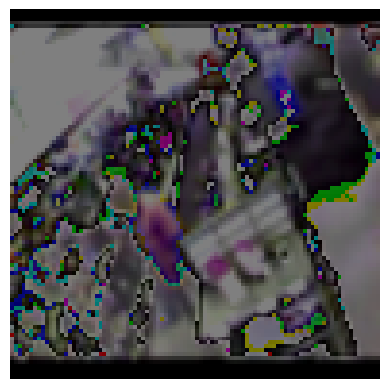

Predicted Class: 0


In [51]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_cam(self, input_tensor, class_idx):
        self.model.eval()
        output = self.model(*input_tensor)
        score = output[:, class_idx]
        
        self.model.zero_grad()
        score.backward(retain_graph=True)

        # Compute Grad-CAM
        weights = torch.mean(self.gradients, dim=[2, 3, 4])  # Global average pooling
        cam = torch.zeros_like(self.activations[0, 0])
        for i, w in enumerate(weights[0]):
            cam += w * self.activations[0, i]
        cam = torch.relu(cam).detach().cpu().numpy()

        # Squeeze to remove extra dimensions
        cam = np.squeeze(cam)

        # Normalize to [0, 1]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


def visualize_grad_cam(cam, frame, alpha=0.5):
    """
    Visualize Grad-CAM on top of a frame.
    Args:
        cam: Grad-CAM heatmap (H, W).
        frame: Original frame (C, H, W).
        alpha: Transparency for overlay.
    """
    # Aggregate activation maps if necessary
    if len(cam.shape) == 3:  # If cam has multiple channels
        cam = np.mean(cam, axis=0)  # Average across channels
        print(f"Combined CAM Shape: {cam.shape}")  # Debugging output

    # Normalize the heatmap
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)  # Normalize to [0, 1]

    # Resize heatmap to match input frame dimensions
    cam_resized = Image.fromarray(np.uint8(255 * cam)).resize((frame.shape[2], frame.shape[1]), Image.BILINEAR)
    cam_resized = np.array(cam_resized)

    # Convert the heatmap to RGB for blending
    cam_resized_rgb = np.stack([cam_resized] * 3, axis=-1)  # Shape: (H, W, 3)

    # Normalize the input frame to [0, 255]
    frame = to_pil_image(frame)
    frame = np.array(frame)

    # Blend the heatmap (RGB) with the input frame
    # Blend heatmap and frame
    overlay = np.uint8(alpha * cam_resized_rgb + (1 - alpha) * frame)

    plt.imshow(overlay)
    plt.axis("off")
    plt.show()




# Example Usage
# Step 1: Load a sample from the dataset
(inputs, label) = test_dataset[0]
sample_rgb, sample_flow = inputs

print(f"RGB Shape: {sample_rgb.shape}")  # (C, T, H, W)
print(f"Flow Shape: {sample_flow.shape}")  # (C, T, H, W)

# Extract the first temporal frame
frame = sample_rgb[:, 0, :, :]  # (C, H, W)

# Step 2: Generate Grad-CAM
grad_cam = GradCAM(model, model.rgb_stream.layer2[-1])  # Use layer2 instead of layer3
cam = grad_cam.generate_cam((sample_rgb.unsqueeze(0).to(device), 
                             sample_flow.unsqueeze(0).to(device)), target_class)

print(f"Grad-CAM Shape (Before Aggregation): {cam.shape}")  # (C, H, W)

# Step 3: Visualize the Grad-CAM
visualize_grad_cam(cam, frame)

# Get model predictions for the input
outputs = model(sample_rgb.unsqueeze(0).to(device), sample_flow.unsqueeze(0).to(device))
predicted_class = torch.argmax(outputs, dim=1).item()
print(f"Predicted Class: {predicted_class}")



INFERENCE FOR BEST MODEL

In [1]:
import os
import torch
import cv2
from torchvision import transforms
from PIL import Image


In [2]:
import torch.nn as nn
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights

class OptimizedMultiStreamR2Plus1D(nn.Module):
    def __init__(self, num_classes):
        super(OptimizedMultiStreamR2Plus1D, self).__init__()

        # Shared stream (pretrained backbone)
        self.shared_stream = r2plus1d_18(weights=R2Plus1D_18_Weights.DEFAULT)
        in_features = self.shared_stream.fc.in_features  # Save in_features before replacing fc
        self.shared_stream.fc = nn.Identity()  # Remove final FC layer

        # Shared fully connected layer
        self.shared_fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)  # Output logits for each modality
        )

        # Fusion layer
        self.fc_fusion = nn.Sequential(
            nn.Linear(2 * num_classes, num_classes),
            nn.ReLU(),
            nn.LayerNorm(num_classes)
        )

    def forward(self, rgb_input, flow_input):
        # Process inputs through shared backbone
        rgb_features = self.shared_stream(rgb_input)
        flow_features = self.shared_stream(flow_input)

        # Process features through shared fully connected layer
        rgb_out = self.shared_fc(rgb_features)
        flow_out = self.shared_fc(flow_features)

        # Concatenate outputs and pass through fusion layer
        combined_out = torch.cat((rgb_out, flow_out), dim=1)
        fused_out = self.fc_fusion(combined_out)

        return fused_out


In [3]:
# Define the categories
categories = ["Shoplifting", "RoadAccidents", "Fighting"]

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptimizedMultiStreamR2Plus1D(num_classes=len(categories)).to(device)

# Load the checkpoint
checkpoint_path = "checkpoints/three/checkpoint_epoch_8.pth"  # Replace with your path
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


C:\Users\adars\AppData\Local\Temp\ipykernel_13736\3154701892.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


OptimizedMultiStreamR2Plus1D(
  (shared_stream): VideoResNet(
    (stem): R2Plus1dStem(
      (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv2Plus1D(
            (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
            (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
          )
       

In [4]:
# Define transformations for resizing, normalizing, and converting frames to tensors
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [5]:
def preprocess_frames(frames, transform, sequence_length):
    
    processed_frames = [transform(Image.fromarray(frame)) for frame in frames]
    if len(processed_frames) < sequence_length:
        # Pad frames if there are fewer than sequence_length
        while len(processed_frames) < sequence_length:
            processed_frames.append(processed_frames[-1])
    else:
        processed_frames = processed_frames[:sequence_length]

    sequence = torch.stack(processed_frames, dim=1)  # Shape: (C, T, H, W)
    return sequence.unsqueeze(0)  # Add batch dimension


In [6]:
def infer_single_video(video_path, model, transform, sequence_length, device, categories):
    
    model.eval()  # Set model to evaluation mode

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR (OpenCV format) to RGB and then to PIL Image
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)

        # Apply transformations
        frame = transform(frame)
        frames.append(frame)

    cap.release()

    # Skip if no frames are available
    if not frames:
        print(f"No frames found in video: {video_path}")
        return None

    # Pad frames if they are fewer than sequence_length
    if len(frames) < sequence_length:
        print(f"Padding video: {video_path} (not enough frames)")
        while len(frames) < sequence_length:
            frames.append(frames[-1].clone())

    # Convert frames to a tensor
    video_tensor = torch.stack(frames[:sequence_length])  # Shape: (T, C, H, W)
    video_tensor = video_tensor.permute(1, 0, 2, 3).unsqueeze(0)  # Shape: (1, C, T, H, W)

    # Perform inference
    with torch.no_grad():
        video_tensor = video_tensor.to(device)
        outputs = model(video_tensor, video_tensor)  # Pass RGB and Flow (both same for demo)
        _, predicted_class_idx = torch.max(outputs, 1)

    # Map the predicted class index to the category name
    predicted_category = categories[predicted_class_idx.item()]

    return {
        "predicted_class_index": predicted_class_idx.item(),
        "predicted_category": predicted_category
    }


In [17]:
# Path to the single video file
video_path = "WhatsApp Video 2024-11-27 at 16.09.09_e0f0944c.mp4"  # Replace with your video file path

# Perform inference
result = infer_single_video(video_path, model, transform, sequence_length=16, device=device, categories=categories)

# Print the results
if result:
    print(f"Predicted Class Index: {result['predicted_class_index']}")
    print(f"Predicted Category: {result['predicted_category']}")
else:
    print("Inference failed.")


Predicted Class Index: 2
Predicted Category: Fighting


experiment

In [14]:
def infer_single_video_with_logging(video_path, model, transform, sequence_length, device, categories):
    
    model.eval()  # Set model to evaluation mode

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    frames = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR (OpenCV format) to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)

        # Apply transformations
        frame = transform(frame)
        frames.append(frame)

    cap.release()

    if not frames:
        raise ValueError(f"No frames found in video: {video_path}")

    # Divide frames into sequences
    sequences = []
    for i in range(0, len(frames) - sequence_length + 1, sequence_length):
        sequence = torch.stack(frames[i:i + sequence_length], dim=1)  # Shape: (C, T, H, W)
        sequences.append(sequence.unsqueeze(0))  # Add batch dimension

    # Log intermediate predictions
    intermediate_predictions = []
    for seq_idx, sequence in enumerate(sequences):
        sequence = sequence.to(device)
        with torch.no_grad():
            outputs = model(sequence, sequence)  # Pass RGB and Flow (both same for demo)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predicted_class_idx = probabilities.argmax(dim=1).item()
            predicted_category = categories[predicted_class_idx]

            # Log prediction
            print(f"Sequence {seq_idx + 1}: Predicted Index: {predicted_class_idx}, "
                  f"Predicted Category: {predicted_category}, "
                  f"Probabilities: {probabilities.cpu().numpy()}")

            intermediate_predictions.append(predicted_category)

    # Final prediction (e.g., majority voting)
    final_prediction = max(set(intermediate_predictions), key=intermediate_predictions.count)

    return {
        "final_prediction": final_prediction,
        "intermediate_predictions": intermediate_predictions
    }


In [18]:
video_path = "WhatsApp Video 2024-11-27 at 16.09.09_e0f0944c.mp4"
categories = ["Shoplifting", "RoadAccidents", "Fighting"]

result = infer_single_video_with_logging(video_path, model, transform, 16, device, categories)

print("\nFinal Prediction:")
print(f"Category: {result['final_prediction']}")
print(f"Intermediate Predictions: {result['intermediate_predictions']}")


Sequence 1: Predicted Index: 2, Predicted Category: Fighting, Probabilities: [[0.32892197 0.31432545 0.3567526 ]]
Sequence 2: Predicted Index: 2, Predicted Category: Fighting, Probabilities: [[0.32892197 0.31432545 0.3567526 ]]
Sequence 3: Predicted Index: 2, Predicted Category: Fighting, Probabilities: [[0.32892197 0.31432545 0.3567526 ]]
Sequence 4: Predicted Index: 2, Predicted Category: Fighting, Probabilities: [[0.32892197 0.31432545 0.3567526 ]]
Sequence 5: Predicted Index: 2, Predicted Category: Fighting, Probabilities: [[0.32892197 0.31432545 0.3567526 ]]
Sequence 6: Predicted Index: 0, Predicted Category: Shoplifting, Probabilities: [[0.8422868  0.07475316 0.08296007]]
Sequence 7: Predicted Index: 0, Predicted Category: Shoplifting, Probabilities: [[0.8487486  0.07170787 0.07954346]]
Sequence 8: Predicted Index: 2, Predicted Category: Fighting, Probabilities: [[0.32892197 0.31432545 0.3567526 ]]
Sequence 9: Predicted Index: 2, Predicted Category: Fighting, Probabilities: [[0.3